# Project 1, Part 5, Data Visualization



# Included Modules and Packages

Code cell containing your includes for modules and packages

In [10]:
import math
import numpy as np
import pandas as pd

import psycopg2

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [11]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)
    

In [12]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

# 1.5 Example of a Data Visualization created using Python

The data science team would like for you to create an example of a data visualization using Python from data in a Pandas dataframe containing data from an SQL query.

Write 1 and only 1 query.  Note that the query may have as many subqueries, including with clauses, as you wish. 

Once you have the data in a Pandas dataframe, you may write as much Python code as you wish to produce the data visualization.

You may only use Python modules that are currently installed in the Anaconda Docker container.  You may not install additional modules or any other software.

All work must be done in Docker in your VM in AWS.  You may not use any external data visualization systems, such as Tableau, etc.

You may use any code from the labs to pattern your code after, however for the data visualization, you cannot wholesale copy a data visualization from the labs.

Ensure that it is properly titled, including titles for axes if present.

Ensure that when you check this Juptyer Notebook into GitHub that the query results in the Pandas dataframe are clearly visible  and that the data visualization is clearly visible.



In [13]:
rollback_before_flag = True
rollback_after_flag = True

query = """

with a as (
            select p.description as product, 
                sum(l.quantity) * 12 as total_sales_for_product
            from sales as sa
            join line_items as l
                on sa.store_id = l.store_id and sa.sale_id = l.sale_id
            join products as p
                on l.product_id = p.product_id
            group by product
          )
          ,
     b as (
            select sum(sa.total_amount) as total_sales 
            from sales as sa     
          )
select a.product, 
       a.total_sales_for_product, 
       round((a.total_sales_for_product / b.total_sales) * 100, 1) as percentage_of_total_sales 
from a, b
order by 3 desc
;

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,product,total_sales_for_product,percentage_of_total_sales
0,Pistachio Salmon,21945336,22.2
1,Eggplant Lasagna,19188696,19.4
2,Curry Chicken,16426608,16.6
3,Teriyaki Chicken,13740156,13.9
4,Brocolli Stir Fry,10967808,11.1
5,Tilapia Piccata,8246844,8.4
6,Spinach Orzo,5481228,5.6
7,Chicken Salad,2742732,2.8


In [55]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


def plot_bar_stacked_grouped(group_dfs, grouped_vars, stacked_vars, groups, colors, figsize, horizontal=True):
    num_grouped_vars = len(grouped_vars)
    num_stacked_vars = len(stacked_vars) 
    num_groups = len(groups)
    
    ax = plt.subplot(1, 1, 1)

    for df in group_dfs:
        ax = df.plot(kind=("barh" if horizontal else "bar"), stacked=True, ax=ax, legend=False, figsize=figsize, grid=True)
                
    h, l = ax.get_legend_handles_labels()
    for i in range(num_grouped_vars):
        for j, pa in enumerate(h[i * num_stacked_vars : (i + 1) * num_stacked_vars]):
            for rect in pa.patches:
                group_width = float(num_grouped_vars + 1)
                bar_width = 1 / group_width
                if horizontal:
                    # Existing y -> center vertically by adjusting for thinner bar size -> offset up to the top of the grouping -> subtract the correct number of bars
                    rect.set_y(rect.get_y() + (rect.get_height() - bar_width) / 2. + bar_width * ((num_grouped_vars - 1) / 2.) - bar_width * i)
                    rect.set_height(bar_width)
                else:
                    # Existing x -> center horizontally by adjusting for thinner bar size -> offset up to the left of the grouping -> add the correct number of bars
                    rect.set_x(rect.get_x() + (rect.get_width() - bar_width) / 2. - bar_width * ((num_grouped_vars - 1) / 2.) + bar_width * i)
                    rect.set_width(bar_width)
                rect.set_facecolor(colors[i][j])
                rect.set_linewidth(1)

    if horizontal:
        ax.set_yticks((np.arange(0, 2 * num_groups, 2) + 1 / float(num_grouped_vars + 1)) / 2. - (1 / float(num_grouped_vars + 1) * 0.5))
        ax.set_yticklabels(df.index, rotation=0, fontsize=12)
    else:
        ax.set_xticks((np.arange(0, 2 * num_groups, 2) + 1 / float(num_grouped_vars + 1)) / 2. - (1 / float(num_grouped_vars + 1) * 0.5))
        ax.set_xticklabels(df.index, rotation=90, fontsize=12)
    
    swatches = []
    labels = []
    for i in range(num_grouped_vars):
        for j in range(num_stacked_vars):
            swatches.append(Line2D([0], [0], color=colors[i][j], lw=4))
            labels.append(f"{stacked_vars[j]} ({grouped_vars[i]})" if len(stacked_vars) > 1 else f"{grouped_vars[i]}")
    ax.legend(swatches, labels, fontsize=12)
    
    return ax

Text(0, 0.5, 'Products')

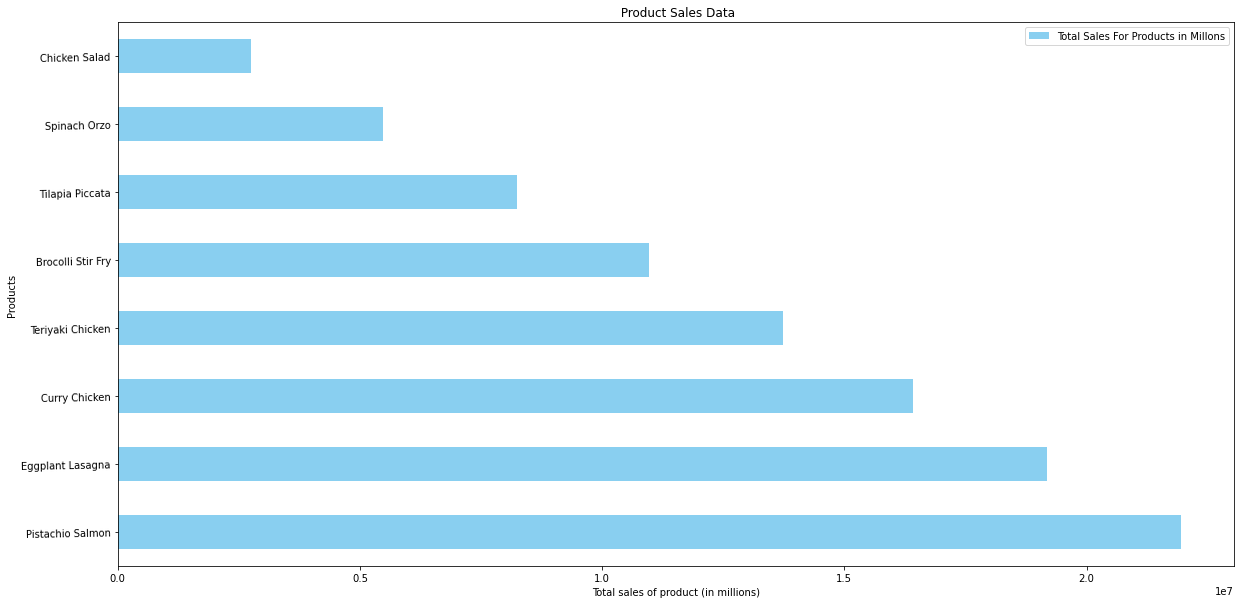

In [79]:
total_sales = df['total_sales_for_product']
#percentage = df['percentage_of_total_sales']

total_sales.index = ["Pistachio Salmon","Eggplant Lasagna","Curry Chicken","Teriyaki Chicken","Brocolli Stir Fry","Tilapia Piccata","Spinach Orzo","Chicken Salad"]
percentage.index = ["Pistachio Salmon","Eggplant Lasagna","Curry Chicken","Teriyaki Chicken","Brocolli Stir Fry","Tilapia Piccata","Spinach Orzo","Chicken Salad"]

new = pd.DataFrame({"Total Sales For Products in Millons": total_sales})

ax = new.plot(kind="barh", figsize=(20, 10),color=['#89CFF0'],rot=1)


ax.set_title(" Product Sales Data")
ax.set_xlabel("Total sales of product (in millions)")
ax.grid(False)
ax.set_ylabel("Products")

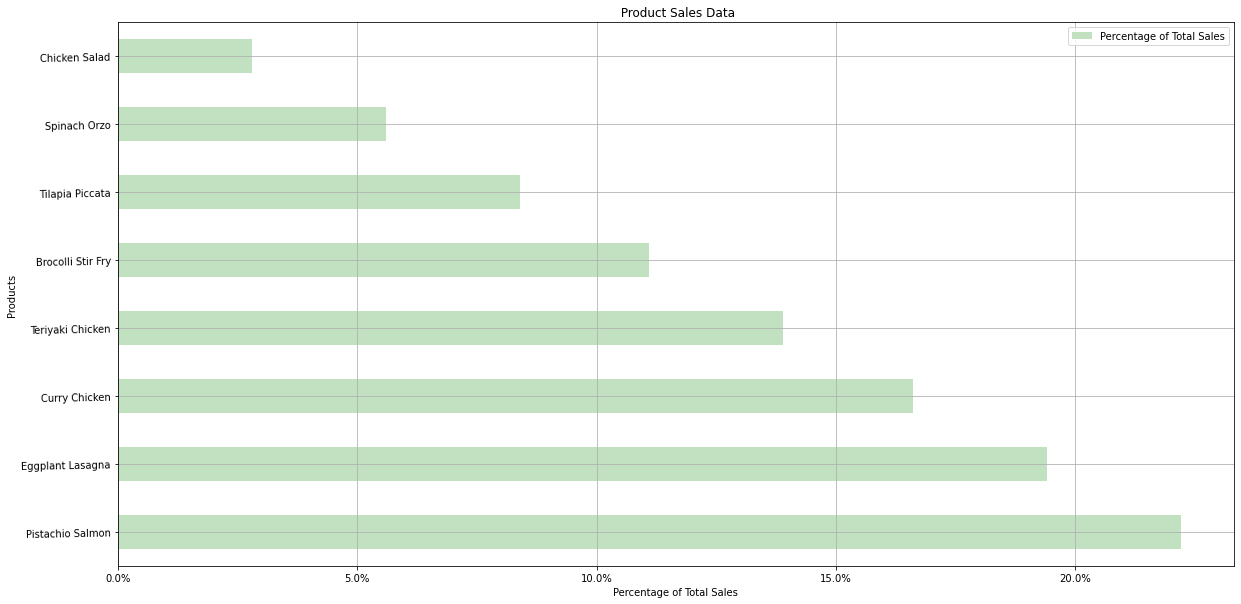

In [80]:
#total_sales = df['total_sales_for_product']
percentage = df['percentage_of_total_sales']

total_sales.index = ["Pistachio Salmon","Eggplant Lasagna","Curry Chicken","Teriyaki Chicken","Brocolli Stir Fry","Tilapia Piccata","Spinach Orzo","Chicken Salad"]
percentage.index = ["Pistachio Salmon","Eggplant Lasagna","Curry Chicken","Teriyaki Chicken","Brocolli Stir Fry","Tilapia Piccata","Spinach Orzo","Chicken Salad"]

new = pd.DataFrame({"Percentage of Total Sales": percentage})

ax = new.plot(kind="barh", figsize=(20, 10),color=['#C1E1C1'],rot=1)


ax.set_title(" Product Sales Data")
ax.set_xlabel("Percentage of Total Sales")
ax.grid(True)
ax.set_ylabel("Products")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(100.0))